**Sugarcane Disease Veri Seti**

Keras Kurulumu

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.6 MB/s eta 0:00:00


# **Datasetin çıkartılıp hazırlanması**

Öncelikle gerekli olan kütüphaneleri ekliyoruz ardından colabi google drive ile bağlıyoruz, ardından Datasetimizin bulunduğu ZIP dosyasını çıkartıyoruz.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_tuner as kt
import zipfile
import os
from google.colab import drive
from glob import glob
import shutil
import random
import itertools

In [ ]:
# Drive Bağlantısı
if os.path.isdir('/content/drive/MyDrive'):
    print("Google Drive zaten bağlı.")
else:
    drive.mount('/content/drive')
    print("Google Drive başarıyla bağlandı.")


Mounted at /content/drive
Google Drive başarıyla bağlandı.


In [ ]:
zip_path = '/content/drive/MyDrive/Sugarcane Disease.zip'

# Dizin belirliyoruz
extract_path = '/content/sugarcane_disease'

# Dizin boşmu dolumu kontrol ediyoruz.
if os.listdir(extract_path):
    print("Dizin zaten dosyalar içeriyor, zip dosyası tekrar çıkartılmadı.")
else:
    #   Boşsa çıkarıyoruz.
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Zip dosyası başarıyla çıkartıldı.")

Zip dosyası başarıyla çıkartıldı.


Modelimin batch boyutu ve parametreleri

In [ ]:
# Veri setinin olduğu dizin
data_dir = "/content/sugarcane_disease"

# Parametrelerimiz
batch_size = 32
img_size = (224, 224)
seed = 123
val_split = 0.1
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

In [ ]:
# Test verilerini ayırmak için dosya oluşturuyoruz.
base_dir = "/content/sugarcane_split"
os.makedirs(base_dir, exist_ok=True)

# Root dizini kontrol ediyoruz, eğer dizinde bir dosya yoksa test ve train dosyalarını oluşması için
if not os.path.exists(base_dir) or not os.listdir(base_dir):
    os.makedirs(base_dir, exist_ok=True)

    # oluşan klasörlere train ve test verilerini aktarıyoruz.
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    print(f"Dizinler başarıyla oluşturuldu: {train_dir} ve {test_dir}")
else:
    print(f"Dizin zaten mevcut ve dosyalar içeriyor: {base_dir}")

Dizinler başarıyla oluşturuldu: /content/sugarcane_split/train ve /content/sugarcane_split/test


In [ ]:
# Train ve Test klasörlerinin alt klasörlerin içinde daha önce sınıflarımız için dosyalar oluşmuş mu diye kontrol ediyoruz
train_classes_exist = all(os.path.exists(os.path.join(train_dir, c)) and os.listdir(os.path.join(train_dir, c)) for c in classes)
test_classes_exist = all(os.path.exists(os.path.join(test_dir, c)) and os.listdir(os.path.join(test_dir, c)) for c in classes)

# Eğer sınıf klasörleri oluşturulmadıysa oluşturuyoruz.
if train_classes_exist and test_classes_exist:
    print("Train ve Test dizinlerinde sınıf alt klasörleri zaten mevcut ve dolu. İşlem yapılmadı.")
else:
    # Train ve Test alt klasörlerini oluşturma
    for c in classes:
        os.makedirs(os.path.join(train_dir, c), exist_ok=True)
        os.makedirs(os.path.join(test_dir, c), exist_ok=True)

    # Orijinal klasörden tüm resimleri okuyoruz.
    all_images = []
    for c in classes:
        class_images = glob(os.path.join(data_dir, c, "*.jpeg"))
        for img_path in class_images:
            all_images.append((img_path, c))

    # Verileri karıştırıp %70e %30 oranında ayırıyoruz.
    random.shuffle(all_images)
    total_images = len(all_images)
    test_count = int(total_images * 0.3)  # %30 test
    train_count = total_images - test_count  # %70 train

    train_images = all_images[:train_count]
    test_images = all_images[train_count:]

    # Dosyaları kopyala yerleştiriyoruz.
    for img_path, c in train_images:
        shutil.copy(img_path, os.path.join(train_dir, c))
    for img_path, c in test_images:
        shutil.copy(img_path, os.path.join(test_dir, c))

    # Train ve Validation seti oluşturma
    train_ds = image_dataset_from_directory(
        train_dir,
        validation_split=0.1,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    val_ds = image_dataset_from_directory(
        train_dir,
        validation_split=0.1,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size
    )

    # Test seti oluşturma
    test_ds = image_dataset_from_directory(
        test_dir,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False  # Test setinde shuffle kapalı
    )

    # Sınıf bilgilerini al
    class_names = train_ds.class_names
    num_classes = len(class_names)

    print(f"Sınıflar: {class_names}")
    print(f"Toplam sınıf sayısı: {num_classes}")
    print(f"Train ve Test klasörleri başarıyla dolduruldu: {train_dir}, {test_dir}")
    print(f"Veri setleri başarıyla oluşturuldu.")

Found 1765 files belonging to 5 classes.
Using 1589 files for training.
Found 1765 files belonging to 5 classes.
Using 176 files for validation.
Found 756 files belonging to 5 classes.
Sınıflar: ['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']
Toplam sınıf sayısı: 5
Train ve Test klasörleri başarıyla dolduruldu: /content/sugarcane_split/train, /content/sugarcane_split/test
Veri setleri başarıyla oluşturuldu.



Performansı iyileştirmek için prefetch kullanıyoruz buda batch eğitiminde bir sonraki batch in belleğe yüklenmesini sağlıyor, eğitim ve veri yükleme paralel ileriyor.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # Prefetch için otomatik olarak en uygun buffer boyutu belirler.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# **Hiperparametre Arama**
Hiperparametre aramak için bir fonksiyon yazıyoruz, modelin performansını optimize etmesi için.

Klasik CNN mimarisi kullandık katmanlar:Conv2D -> MaxPooling -> Conv2D -> MaxPooling -> Conv2D -> MaxPooling  ->  Flatten -> Dense


In [ ]:
# Hiperparametre arama için model inşa fonksiyonu
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)))
    # Modele katmanları sırayla ekleyip, gelecek olan görüntülerin piksel değerlerini 0-1 aralığında yapıyoruz.

    hp_filters_1 = hp.Int('filters_1', min_value=32, max_value=64, step=32)
    hp_filters_2 = hp.Int('filters_2', min_value=64, max_value=128, step=64)
    hp_filters_3 = hp.Int('filters_3', min_value=128, max_value=256, step=64)

    model.add(layers.Conv2D(hp_filters_1, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(hp_filters_2, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(hp_filters_3, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())

    hp_units = hp.Int('units', min_value=64, max_value=256, step=64)
    model.add(layers.Dense(hp_units, activation='relu'))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Hyperband arama algoritması ile hiperparametre optimizasyonu yapacak bir tuner nesnesi oluşturuyoruz.
# Daha önce oluşturduğumuz fonksiyonu kullanarak hiperparametreleri alıyor ve Keras modeli oluşturuyoruz
# val_accuracy, arama sürecinde kriter olarak accuracy metriğini kullanacağını belirtiyoruz.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='hp_search',
    project_name='hp_optimization',
    overwrite=False
)

# Modelin eğitim sırasında doğrulama kaybını izler ve eğer ardışık 3 epoch boyunca iyileşme olmazsa eğitimi erken sonlandırır.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# En iyi modeli kaydedeceğimiz dizin.
model_save_path = "best_model.h5"

if os.path.exists(model_save_path):
    print("Daha önce eğitilmiş model bulundu. Model yükleniyor...")
    model = keras.models.load_model(model_save_path)
else:
    try:
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        # best_hps bulunabildiyse, arama tamamlanmıştır, yeniden search yapmaya gerek yok
        print("Daha önce bulunmuş en iyi hiperparametreler mevcut, arama yapılmayacak.")
    except:
        # best_hps yoksa arama yap
        print("Hiperparametre araması yapılıyor...")
        tuner.search(train_ds, validation_data=val_ds, epochs=5, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi hiperparametreler:")
print(f"Filters_1: {best_hps.get('filters_1')}")
print(f"Filters_2: {best_hps.get('filters_2')}")
print(f"Filters_3: {best_hps.get('filters_3')}")
print(f"Units: {best_hps.get('units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Tunerin bulduğu en iyi hiperparametre seti ile modeli sıfırdan inşaat ediyoruz
model = tuner.hypermodel.build(best_hps)

# 10 epoch boyunca train_ds üzerinde eğitim yapıp val_ds üzerinde doğrlama yapıyoruz.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[stop_early]
)

#Modeli kaydediyoruz.
model.save(model_save_path)

Trial 10 Complete [00h 01m 23s]
val_accuracy: 0.6590909361839294

Best val_accuracy So Far: 0.7727272510528564
Total elapsed time: 00h 10m 21s
En iyi hiperparametreler:
Filters_1: 64
Filters_2: 64
Filters_3: 192
Units: 192
Learning Rate: 0.001
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.2097 - loss: 2.5100 - val_accuracy: 0.1648 - val_loss: 1.5603
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 230ms/step - accuracy: 0.3528 - loss: 1.4331 - val_accuracy: 0.3920 - val_loss: 1.3432
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.4885 - loss: 1.2599 - val_accuracy: 0.5511 - val_loss: 1.2287
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.6046 - loss: 1.0123 - val_accuracy: 0.5341 - val_loss: 1.1178
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.6644 - loss: 0.8420 - val_accuracy: 0.7216 - val_loss: 0.8583
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - accuracy: 0.7698 - loss: 0.6124 - val_accuracy: 0.7330 -

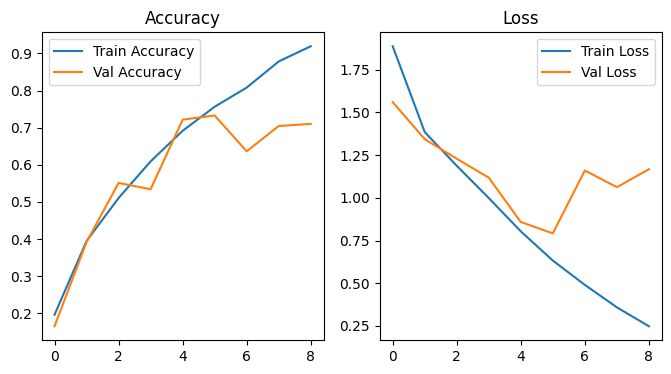

In [ ]:
# Eğitim grafikleri
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

# Test setinde tahminler
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_prob.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred)
# MCC
mcc = matthews_corrcoef(y_true, y_pred)
# Precision, Recall, F1 (macro average)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1 (macro):", f1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.6479 - loss: 1.3684
Test Accuracy: 0.658730149269104
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Confusion Matrix:
 [[111  35  11  10   8]
 [ 25 101  11  11   5]
 [  0   1 111  24   9]
 [  4   3  28  91   2]
 [  6  18  39   8  84]]
Classification Report:
               precision    recall  f1-score   support

     Healthy       0.76      0.63      0.69       175
      Mosaic       0.64      0.66      0.65       153
      RedRot       0.56      0.77      0.64       145
        Rust       0.63      0.71      0.67       128
      Yellow       0.78      0.54      0.64       155

    accuracy                           0.66       756
   macro avg       0.67      0.66      0.66       756
weighted avg       0.68      0.66      0.66       756



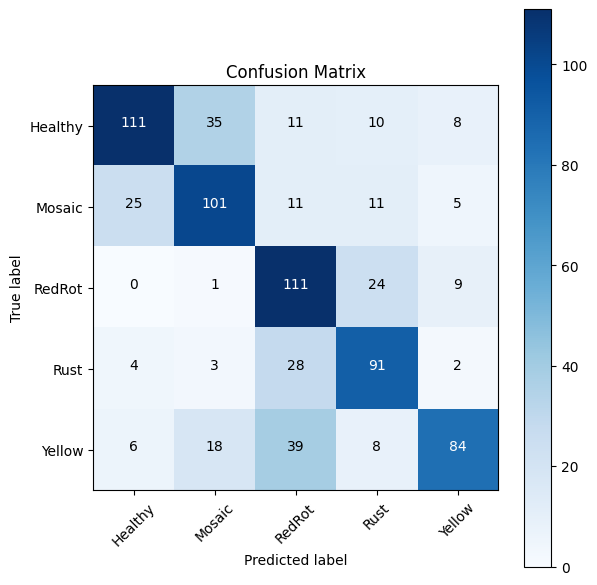

In [ ]:
# Karmaşıklık Matrisi Görselleştirme
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm_sum = cm.sum(axis=1)[:, np.newaxis]
        cm = cm.astype('float') / cm_sum
        cm = np.nan_to_num(cm)
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val_str = f"{cm[i,j]:.2f}" if normalize else str(cm[i,j])
        plt.text(j, i, val_str,
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Normal Confusion Matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

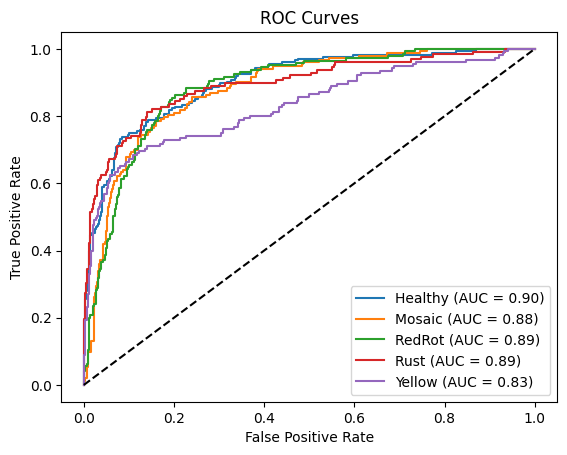

Macro Average ROC AUC: 0.8796908465652693


In [ ]:
# ROC ve AUC
y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Makro ortalama AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
macro_roc_auc = auc(all_fpr, mean_tpr)

# ROC Eğrisi
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

print("Macro Average ROC AUC:", macro_roc_auc)